<a href="https://colab.research.google.com/github/adarshlearnngrow/StepUp-AI/blob/Clustering/ClusteringMentor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [4]:
from openai import OpenAI
import json
import time
from google.colab import userdata
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
import joblib
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import os
pd.set_option('display.max_colwidth', None)

In [5]:
client = OpenAI(api_key=userdata.get("Open_AI_API_KEY"))

## Prompt to generate Mentors with skills of experties

In [161]:
def generate_mentor_prompt(role, tech_skills, n=10):
    prompt = f"""
You are an assistant helping to create a database of expert mentors.

Generate {n} mentor profiles for the role: "{role}".

Each mentor should have:
- A realistic name
- A short professional bio (1–2 sentences)
- A list of 5–7 technical skills (from this list):
  {', '.join(tech_skills)}

Return the output in this JSON format:
[
  {{
    "name": "Mentor Name",
    "bio": "Short mentor bio.",
    "linkedin_id": "Mentor LinkedIn ID",
    "technical_skills": ["skill1", "skill2", ...]
  }},
  ...
]
"""
    return prompt

# Load role + skill data
with open("role_skills.json") as f:
    roles_data = json.load(f)

# Collection
all_mentors = []
mentor_counter = 1

# Generate mentors for each role
for role_info in roles_data:
    role = role_info["role"]
    tech_skills = role_info["technical_skills"]

    prompt = generate_mentor_prompt(role, tech_skills, n=25)

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7
        )

        raw_output = response.choices[0].message.content.strip()
        mentors = json.loads(raw_output)

        for mentor in mentors:
            mentor["mentor_id"] = f"M{mentor_counter:04d}"
            mentor["role"] = role
            mentor_counter += 1

        all_mentors.extend(mentors)
        print(f"Added {len(mentors)} mentors for role: {role}")

    except Exception as e:
        print(f"Error processing role {role}: {e}")

# ✅ Save to JSON
with open("generated_mentors.json", "w") as f:
    json.dump(all_mentors, f, indent=2)

print(f"\n✅ All mentor profiles saved to 'generated_mentors.json' ({len(all_mentors)} total).")

Added 26 mentors for role: AI Engineer
Added 26 mentors for role: Business Analyst
Added 25 mentors for role: Business Intelligence Analyst
Added 26 mentors for role: Data Analyst
Added 25 mentors for role: Machine Learning

✅ All mentor profiles saved to 'generated_mentors.json' (128 total).


In [162]:
mentors_final_data = pd.read_json("generated_mentors.json")
mentors_final_data.set_index("mentor_id", inplace=True)
mentors_final_data.head(5)

,name,bio,linkedin_id,technical_skills,role
mentor_id,,,,,
M0001,Alice Chen,AI Engineer with 8 years of experience in developing machine learning models for predictive analytics.,alicechen_ai,"[Machine Learning, Artificial Intelligence, Data Analysis, Programming (Python), Statistical Analysis]",AI Engineer
M0002,John Smith,Experienced AI Engineer specializing in computer vision and deep learning algorithms.,johnsmith_ai,"[Artificial Intelligence, Computer Vision, Machine Learning, Data Analysis, Algorithm Development]",AI Engineer
M0003,Emily Wong,Data scientist with expertise in natural language processing and big data technologies.,emilywong_ai,"[Natural Language Processing, Big Data Technologies, Data Analysis, Machine Learning, Programming (Python)]",AI Engineer
M0004,David Lee,AI Engineer with a background in cloud computing and software development.,davidlee_ai,"[Cloud Computing, Software Development, Artificial Intelligence, Machine Learning, Data Management]",AI Engineer
M0005,Sarah Johnson,Experienced AI Engineer proficient in data visualization and statistical analysis.,sarahjohnson_ai,"[Data Visualization, Statistical Analysis, Machine Learning, Artificial Intelligence, Programming (Python)]",AI Engineer


### Vectorizing the skill labels

In [165]:
mlb = MultiLabelBinarizer()
skills_matrix = mlb.fit_transform(mentors_final_data['technical_skills'])
skills_df = pd.DataFrame(skills_matrix, columns=mlb.classes_, index=mentors_final_data.index)
skills_df.head(5)

,API Development,Advanced Excel Skills,Agile Methodologies,Algorithm Development,Artificial Intelligence,Big Data Technologies,"Big Data Technologies (Hadoop, Spark)",Business Intelligence Reporting,Business Intelligence Tools,Business Process Modeling,...,SAS,SQL,Software Development,Statistical Analysis,Statistical Analysis Software,Statistical Modeling,"Statistical Software (SAS, MATLAB)",Statistical Software Proficiency,Tableau,Testing and Quality Assurance
mentor_id,,,,,,,,,,,,,,,,,,,,,
M0001,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
M0002,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M0003,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M0004,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
M0005,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Fitting a KMean model with range of cluster k and ran for 100 times to be certain.

✅ Best K = 29 with silhouette score = 0.4291


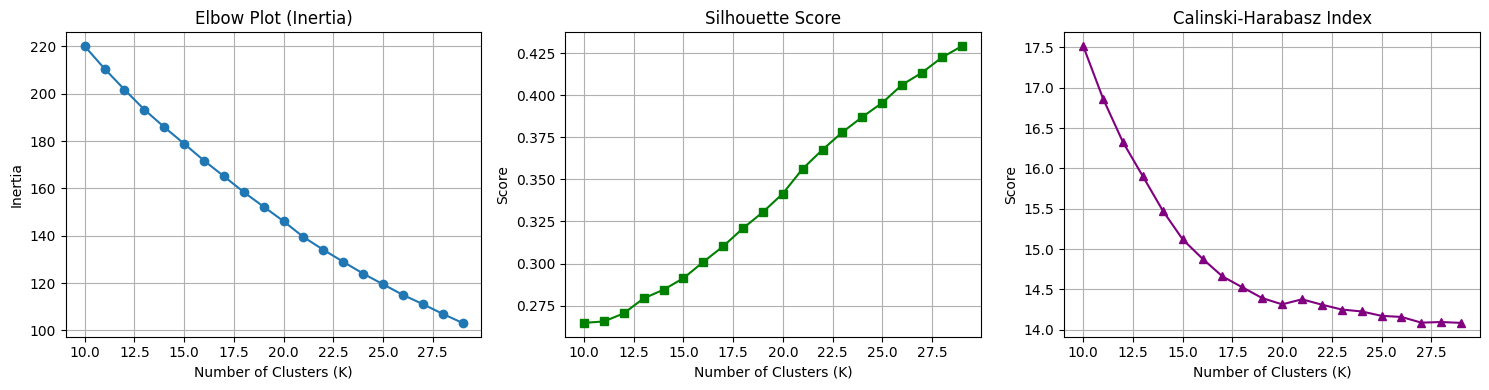

In [166]:
k_val = np.arange(10, 30)
best_k = None
best_score = -1
shilloutte_scores = []
inertias = []
ch_indexs = []

for k in k_val:
    temp_sil_scores = []
    temp_ch_scores = []
    temp_inertias = []

    for run in range(100):  # 100 is heavy; reduce to 5 or 10 for dev
        kmeans = KMeans(n_clusters=k, random_state=run, n_init='auto')
        labels = kmeans.fit_predict(skills_df)

        sil_score = silhouette_score(skills_df, labels)
        ch_index = calinski_harabasz_score(skills_df, labels)

        temp_sil_scores.append(sil_score)
        temp_ch_scores.append(ch_index)
        temp_inertias.append(kmeans.inertia_)

    # Average over all runs
    avg_sil = np.mean(temp_sil_scores)
    avg_ch = np.mean(temp_ch_scores)
    avg_inertia = np.mean(temp_inertias)

    shilloutte_scores.append(avg_sil)
    ch_indexs.append(avg_ch)
    inertias.append(avg_inertia)

    if avg_sil > best_score:
        best_score = avg_sil
        best_k = k

print(f"✅ Best K = {best_k} with silhouette score = {best_score:.4f}")

# 📈 Plot all 3 metrics
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(k_val, inertias, marker='o')
plt.title("Elbow Plot (Inertia)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(k_val, shilloutte_scores, marker='s', color='green')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Score")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(k_val, ch_indexs, marker='^', color='purple')
plt.title("Calinski-Harabasz Index")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Score")
plt.grid(True)

plt.tight_layout()
plt.show()


### Best cluster chosen is 29

In [167]:
best_k = 29
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
mentors_final_data["cluster"] = kmeans_final.fit_predict(skills_df)

# Mount Google Drive
drive.mount('/content/gdrive')

# Define path to save
save_path = "/content/gdrive/My Drive/saved_models"
os.makedirs(save_path, exist_ok=True)

# Save your scikit-learn KMeans model
joblib.dump(kmeans_final, os.path.join(save_path, "mentor_clustering_model.pkl"))

print("KMeans model saved to Google Drive!")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
KMeans model saved to Google Drive!


In [168]:
mentors_final_data.head(5)

,name,bio,linkedin_id,technical_skills,role,cluster
mentor_id,,,,,,
M0001,Alice Chen,AI Engineer with 8 years of experience in developing machine learning models for predictive analytics.,alicechen_ai,"[Machine Learning, Artificial Intelligence, Data Analysis, Programming (Python), Statistical Analysis]",AI Engineer,8
M0002,John Smith,Experienced AI Engineer specializing in computer vision and deep learning algorithms.,johnsmith_ai,"[Artificial Intelligence, Computer Vision, Machine Learning, Data Analysis, Algorithm Development]",AI Engineer,1
M0003,Emily Wong,Data scientist with expertise in natural language processing and big data technologies.,emilywong_ai,"[Natural Language Processing, Big Data Technologies, Data Analysis, Machine Learning, Programming (Python)]",AI Engineer,10
M0004,David Lee,AI Engineer with a background in cloud computing and software development.,davidlee_ai,"[Cloud Computing, Software Development, Artificial Intelligence, Machine Learning, Data Management]",AI Engineer,10
M0005,Sarah Johnson,Experienced AI Engineer proficient in data visualization and statistical analysis.,sarahjohnson_ai,"[Data Visualization, Statistical Analysis, Machine Learning, Artificial Intelligence, Programming (Python)]",AI Engineer,8


### Using TSNE to see if the clustering algorithm is grouping based on skills or based on roles

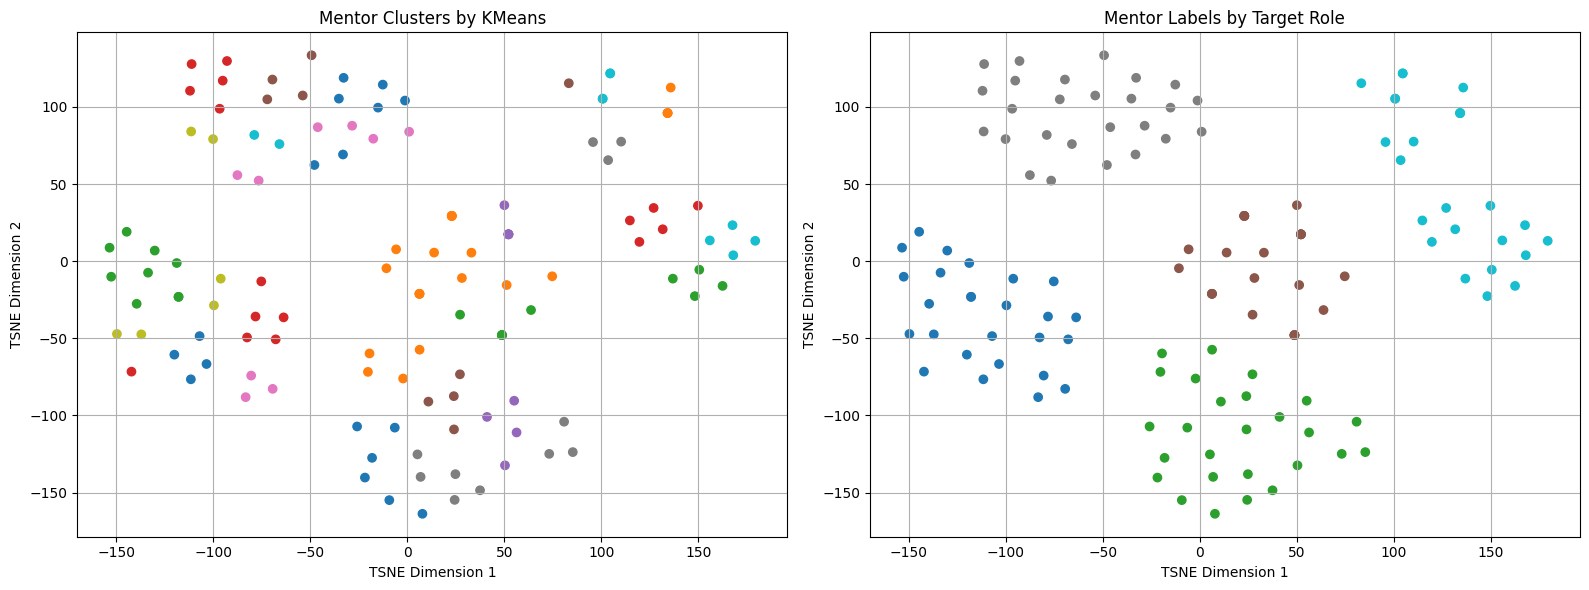

In [181]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(skills_df.values)

plt.figure(figsize=(16, 6))  # one wide figure with 2 subplots

# Subplot 1 — using cluster labels
plt.subplot(1, 2, 1)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=mentors_final_data["cluster"], cmap='tab10')
plt.title("Mentor Clusters by KMeans")
plt.xlabel("TSNE Dimension 1")
plt.ylabel("TSNE Dimension 2")
#plt.(label='Cluster')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=role_labels, cmap='tab10')
plt.title("Mentor Labels by Target Role")
plt.xlabel("TSNE Dimension 1")
plt.ylabel("TSNE Dimension 2")
#plt.colorbar(label='Role Label')
plt.grid(True)

plt.tight_layout()
plt.show()

### Clustering happeining on skills cause within each role there are still overlapping clusters, means skills are common within each roles

### Prediction on actual student skill gap

In [182]:
#predicting on a student

# Load student skill gap
student_data = pd.read_json("skill_gap_analysis.json")
skill_gap = student_data.iloc[30]['technical_skill_gap']

skill_gap = [s.strip() for s in skill_gap.split(",")]
skill_gap

# Ensure mlb is already fitted on your mentor skill data
mlb.transform([skill_gap])

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Statistical Analysis (SAS)'] will be ignored
  warnings.warn(


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0]])

In [186]:
prediction = kmeans_final.predict(mlb.transform([skill_gap]))

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Statistical Analysis (SAS)'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [184]:
skill_gap

['Statistical Analysis (SAS)',
 'Data Management',
 'Data Cleaning',
 'ETL Processes',
 'Database Design',
 'Data Warehousing',
 'Excel (Advanced)',
 'Statistical Software Proficiency']

In [189]:
mentors_final_data[mentors_final_data["cluster"] == prediction[0]][['name', 'bio','linkedin_id']]

,name,bio,linkedin_id
mentor_id,,,
M0085,Alex Nguyen,Data analyst specializing in data warehousing and database design.,alexnguyen
M0089,Daniel Kim,Data analyst specializing in ETL processes and data warehousing.,danielkim
M0094,Olivia Kim,Experienced data analyst with a background in SQL and data warehousing.,oliviakim
M0101,Jason Lee,Data analyst specializing in Excel and data warehousing.,jasonlee
